## Example 1: Soving Allen-Cahn equation in 1D with PINN
### Governing equations, boundary and initial conditions
PDE: $$ \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} - \frac{1}{\epsilon^2} f'(u) $$
whwre $$ f(u) = (u^2 - 1)^2 / 4 $$
Domain: $$ x \in [-1, 1], t \in [0, 0.05] $$
Neumann boundary condition: $$ \frac{\partial u}{\partial x} = 0 $$
Initial condition: $$ u(x, 0) = sin(\pi x)*(x+1)^2(x-1)^2 $$

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [2]:
# Step 1. Create a model (Feedforward Neural Network) in PyTorch
# Three-layer fully connected neural network with 100 nodes in each layer
n_nodes = 100
n_out = 1

class PINN(nn.Module):
    def __init__(self, n_nodes, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, n_nodes),
            nn.Tanh(),
            nn.Linear(n_nodes, n_nodes),
            nn.Tanh(),
            nn.Linear(n_nodes, n_nodes),
            nn.Tanh(),
            nn.Linear(n_nodes, n_out)
        )
    def forward(self, x):
        return self.net(x)

model = PINN(n_nodes, n_out).to(device)


## Construct loss function for PINN
### Loss function includes three terms (residuals):
1. For boundary condition: $Loss_{BC} = MSE[u(x=\pm 1, t) - 1]$
2. For initial condition: $Loss_{IC} = MSE[u(x, t=0) - sin(\pi x)*(x-1)^2(x+1)^2]$
3. For PDE: $Loss_{PDE} = MSE[\frac{\partial u(x,t)}{\partial t} + (u-u^3)/eps^2]$
** Total loss function is the weighted sum of the above three terms: **
$$ Loss = Loss_{PDE} + w_1 Loss_{BC} + w_2 Loss_{IC} $$

In [9]:
# Step 2. Construct loss function
eps = 0.1

# Initial condition function
u0 = lambda x: np.sin(np.pi*x)*(x+1)**2*(x-1)**2

def pinn_loss(model, X_PDE, X_IC, X_BC):
    """
    Compute PDE, IC, and BC losses.
    Each X_* is a tensor of shape [N,2] with columns (x,t).
    """
    # --- PDE loss ---
    X_PDE = X_PDE.clone().detach().requires_grad_(True)
    u = model(X_PDE)

    grads = torch.autograd.grad(u, X_PDE, torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:,0:1]
    u_t = grads[:,1:2]

    u_xx = torch.autograd.grad(u_x, X_PDE, torch.ones_like(u_x), create_graph=True)[0][:,0:1]
    loss_PDE = torch.mean(((u_t - u_xx)*eps**2 - (u - u**3))**2)

    # --- IC loss ---
    u_pred_ic = model(X_IC)
    u_true_ic = torch.tensor(u0(X_IC[:,0:1].cpu().numpy()), dtype=torch.float64).to(device)
    loss_IC = torch.mean((u_pred_ic - u_true_ic)**2)

    # --- BC loss (Neumann BC du/dx=0 at x=±1) ---
    X_BC = X_BC.clone().detach().requires_grad_(True)
    u_bc = model(X_BC)
    u_x_bc = torch.autograd.grad(u_bc, X_BC, torch.ones_like(u_bc), create_graph=True)[0][:,0:1]
    loss_BC = torch.mean(u_x_bc**2)

    # --- Total ---
    w1, w2 = 1., 1.
    loss_total = loss_PDE + w1*loss_IC + w2*loss_BC
    return loss_total, loss_PDE, loss_IC, loss_BC


## Prepare the training data for PINN
### Training data only reuqires the collocation points of (x, t) input pairs, no need to provide the corresponding output values
### Training data includes three parts: 
1. For boundary condition:  $x=-1, 1, t \in [0, 0.05]$ 
2. For initial condition: $t = 0, x \in [-1, 1]$ 
3. For PDE: $x \in [-1, 1], t \in [0, 0.05]$

In [10]:
# Step 3.0. Generate training data
def BC_data(Nt):
    x = np.random.choice([-1, 1], size=(Nt,1))
    t = np.random.rand(Nt,1)*0.05
    X = np.hstack((x,t))
    return torch.tensor(X, dtype=torch.float64).to(device)

def IC_data(Nx):
    x = np.random.rand(Nx,1)*2 - 1
    t = np.zeros((Nx,1))
    X = np.hstack((x,t))
    return torch.tensor(X, dtype=torch.float64).to(device)

def PDE_data(Np):
    x = np.random.rand(Np,1)*2 - 1
    t = np.random.rand(Np,1)*0.05
    X = np.hstack((x,t))
    return torch.tensor(X, dtype=torch.float64).to(device)

Nt, Nx, Np = 100, 200, 4000
X_BC = BC_data(Nt)
X_IC = IC_data(Nx)
X_PDE = PDE_data(Np)

# mini-batch dataset for PDE points
batch_size = 256
PDE_batches = list(torch.split(X_PDE, batch_size))



# Step 3.0. Generate training data

Nt = 100  # number of training data for BC
Nx = 200  # number of training data for IC
Np = 4000 # number of training data for PDE

X_BC = BC_data(Nt)
X_IC = IC_data(Nx)
X_PDE = PDE_data(Np)

# Create a dataset object for X_PDE
X_PDE_dataset = tf.data.Dataset.from_tensor_slices(X_PDE)
# Shuffle and batch data
X_PDE_dataset = X_PDE_dataset.shuffle(buffer_size=Np).batch(256)

In [5]:
# Parameter in Allen-Cahn equation
eps = 0.1

# training datasets for IC/BC
N0 = 200
X0 = np.hstack((np.linspace(-1,1,N0)[:,None], np.zeros((N0,1))))
u0_vals = u0(X0[:,0:1])
X0_t = torch.tensor(X0, dtype=torch.float64).to(device)
u0_t = torch.tensor(u0_vals.reshape(-1,1), dtype=torch.float64).to(device)


In [11]:
optimizer = optim.NAdam(model.parameters(), lr=1e-3)
epochs = 3000

for epoch in range(1, epochs+1):
    for X_PDE_batch in PDE_batches:
        optimizer.zero_grad()
        loss_total, loss_PDE, loss_IC, loss_BC = pinn_loss(model, X_PDE_batch, X_IC, X_BC)
        loss_total.backward()
        optimizer.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"Epoch {epoch:5d} | "
              f"Loss = {loss_total.item():.3e}, "
              f"PDE = {loss_PDE.item():.3e}, IC = {loss_IC.item():.3e}, BC = {loss_BC.item():.3e}")


Epoch     1 | Loss = 1.346e-01, PDE = 2.973e-02, IC = 1.020e-01, BC = 2.790e-03
Epoch   100 | Loss = 1.076e-02, PDE = 8.159e-03, IC = 1.996e-03, BC = 6.099e-04
Epoch   200 | Loss = 6.913e-03, PDE = 4.067e-03, IC = 1.706e-03, BC = 1.139e-03
Epoch   300 | Loss = 6.629e-03, PDE = 3.363e-03, IC = 1.672e-03, BC = 1.594e-03
Epoch   400 | Loss = 4.248e-03, PDE = 2.752e-03, IC = 1.345e-03, BC = 1.511e-04
Epoch   500 | Loss = 4.099e-03, PDE = 2.341e-03, IC = 1.135e-03, BC = 6.231e-04
Epoch   600 | Loss = 3.418e-03, PDE = 2.186e-03, IC = 1.142e-03, BC = 8.957e-05
Epoch   700 | Loss = 7.219e-03, PDE = 2.532e-03, IC = 1.638e-03, BC = 3.050e-03
Epoch   800 | Loss = 3.632e-03, PDE = 1.882e-03, IC = 1.015e-03, BC = 7.353e-04
Epoch   900 | Loss = 2.688e-03, PDE = 1.672e-03, IC = 9.022e-04, BC = 1.130e-04
Epoch  1000 | Loss = 2.753e-03, PDE = 1.578e-03, IC = 8.746e-04, BC = 3.010e-04
Epoch  1100 | Loss = 2.799e-03, PDE = 1.467e-03, IC = 8.462e-04, BC = 4.861e-04
Epoch  1200 | Loss = 2.651e-03, PDE = 1.

In [12]:
# Solve Allen–Cahn equation in 1D using finite difference (Forward Euler)
def allen_cahn_fd(u, eps, dt, dx):
    Nx = u.shape[0]
    u0 = np.zeros(Nx+2)
    u0[1:-1] = u
    u0[0] = u0[1]
    u0[-1] = u0[-2]
    ut = np.zeros(Nx)
    for i in range(1,Nx+1):
        ut[i-1] = u0[i] + dt*((u0[i-1]-2*u0[i]+u0[i+1])/dx**2 + (u0[i]-u0[i]**3)/eps**2)
    return ut

eps = 0.1



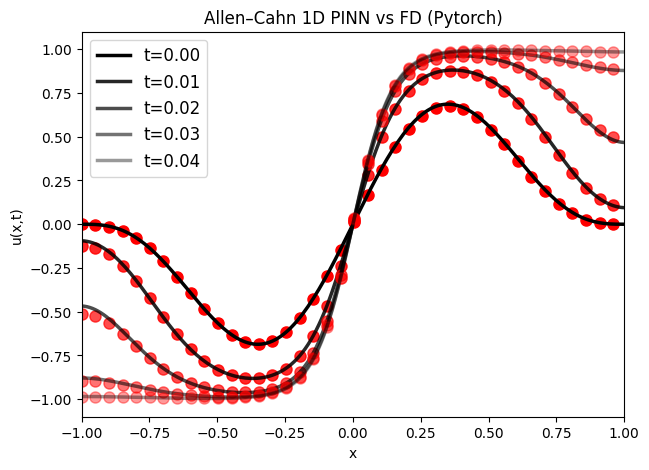

In [13]:
X = np.linspace(-1, 1, 200)
dt = 1e-5
dx = X[1]-X[0]

xlim = [-1,1]; ylim = [-1.1,1.1]

plt.figure(figsize=(7,5))
for tt in [0., 0.01, 0.02, 0.03, 0.04]:
    X_in = np.hstack((X.reshape(-1,1), tt*np.ones((200,1))))
    X_t = torch.tensor(X_in, dtype=torch.float64).to(device)
    with torch.no_grad():
        u_pred = model(X_t).cpu().numpy().flatten()

    # Finite-difference solution
    u_exact = u0(X)
    for _ in range(int(tt/dt)):
        u_exact = allen_cahn_fd(u_exact, eps, dt, dx)

    plt.plot(X, u_pred, 'ro', markevery=5, markersize=8, alpha=max(0.1, 1-15*tt))
    plt.plot(X, u_exact, 'k', lw=2.5, alpha=max(0.1, 1-15*tt), label=f"t={tt:.2f}")

plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel("x"); plt.ylabel("u(x,t)")
plt.legend(fontsize=12)
plt.title("Allen–Cahn 1D PINN vs FD (Pytorch)")
plt.show()

